# DeepLearning/ Word2Vec

## Lecture

![word2vec](images/L5-1a-word2vec.png)
![word2vec](images/L5-1b-word2vec.png)
![word2vec](images/L5-1c-word2vec.png)
![word2vec](images/L5-2a-word2vec.png)
![word2vec](images/L5-2b-word2vec.png)
좌표 평면에 옮길때  PCA를 쓰면 정보 손실이 너무 큼 --> t-SNE
![word2vec](images/L5-2c-word2vec.png)
![word2vec](images/L5-2d-word2vec.png)
![word2vec](images/L5-2e-word2vec.png)
![word2vec](images/L5-2f-word2vec.png)
모든 word를 벡터화 시키는 게 비효율 적이 므로 random sample 이용

![word2vec](images/L5-3a-word2vec.png)
![word2vec](images/L5-3b-word2vec.png)
![word2vec](images/L5-3c-word2vec.png)
![word2vec](images/L5-3d-word2vec.png)


## Assignment 5
The goal of this assignment is to train a Word2Vec skip-gram model over [Text8 data](http://mattmahoney.net/dc/textdata).

** Reference:  **
- [Arn-O](https://github.com/Arn-O/udacity-deep-learning/blob/master/5_word2vec.ipynb)
- [codeOnWeb: Vector Representations of Words](https://codeonweb.com/entry/dcc9ef10-5d8f-47c4-bd6e-27878a9a8b62)


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/Users/Josh/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


read the data into a string:

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f: 
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print ('Data size %d' % len(words))

Data size 17005207


build the dictionary and replace rare words with UNK token.  
딕셔너리를 생성하고 잘 안나오는 단어들은 UNK 토큰으로 대체(확률적으로 적은 단어라고 확률적으로 제외 할 수 없으므로)

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else: 
            index = 0 # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)

    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print ('Most Common words (+ UNK)', count[:5])
print ('Sample data', data[:10])

del words # hint to reduce memory    

Most Common words (+ UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [5]:
print (data[:10])
print (count[:10])
print (dictionary.items()[:10])
print (reverse_dictionary.items()[:10])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
[('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


** * Create skip-gram model**: Function to generate a training batch for the skip-gram model

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    #assert: if condition == False, raiseError  - ymjung
    assert batch_size % num_skips == 0 
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1 # [skip_window, target, skip_window]
    buffer= collections.deque(maxlen = span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size/num_skips):
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2,1), (4,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size = 16, num_skips = num_skips, skip_window = skip_window)
    print ('\n with num_skips = %d and skip_window = %d: ' % (num_skips, skip_window))
    print ('    batch: ', [reverse_dictionary[bi] for bi in batch])
    print ('    labels: ', [reverse_dictionary[li] for li in labels.reshape(16)])
    
for num_skips, skip_window in [(2,1), (4,2)]:
    data_index = 1
    batch, labels = generate_batch(batch_size = 16, num_skips = num_skips, skip_window= skip_window)
    print ('\n with num_skips = %d and skip_window = %d: ' % (num_skips, skip_window))
    print ('    batch: ', [reverse_dictionary[bi] for bi in batch])
    print ('    labels: ', [reverse_dictionary[li] for li in labels.reshape(16)])    


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

 with num_skips = 2 and skip_window = 1: 
    batch:  ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels:  ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of', 'abuse', 'term', 'first', 'of', 'used', 'abuse', 'first', 'against']

 with num_skips = 4 and skip_window = 2: 
    batch:  ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels:  ['term', 'a', 'anarchism', 'originated', 'term', 'as', 'of', 'originated', 'as', 'a', 'abuse', 'of', 'a', 'first', 'abuse', 'term']

 with num_skips = 2 and skip_window = 1: 
    batch:  ['as', 'as', 'a

** * NOTE: the label is a sliding random value of the word surrounding the words of the batch **

In [7]:
print(batch)
print(labels)

[   6    6    6    6  195  195  195  195    2    2    2    2 3137 3137 3137
 3137]
[[3084]
 [   2]
 [  12]
 [ 195]
 [3137]
 [  12]
 [   6]
 [   2]
 [3137]
 [ 195]
 [  46]
 [   6]
 [   2]
 [ 195]
 [  59]
 [  46]]


** * Train skip-gram model:  **

In [10]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector
skip_window = 1 # How many words to consider 
num_skips = 2 # How many times to reuse an input to generate a label

# we pick a random validation set to sample nearest neighbors. 
# here we limit the validation samples to the words that have a low numeric ID, 
# which by construction are also the most frequent

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # ONly pick dev samples in the head of the distribution
valid_examples  = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # Input Data
    train_dataset = tf.placeholder(tf.int32, shape =[batch_size] )
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev= 1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    # Look up embedding for inputs
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    # Compute the softmax loss, using a sample of the negative labels each time
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, 
                                                    train_labels, num_sampled, vocabulary_size))
    
    # Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings
    # we use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Run Session:

In [12]:
num_steps = 100001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += l
        
        if step % 2000 ==0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches
            print('>>> AVerage loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
        # Note that this is expensive(~ 20% slowdown if computed every 500 steps)
        if step % 10000 ==0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s: ' % valid_word

                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print (log)
    final_embeddings = normalized_embeddings.eval()         
                

Initialized
>>> AVerage loss at step 0: 8.039938
Nearest to they:  keeshonden, heard, acquiescence, signed, nazism, devises, zara, crashing,
Nearest to but:  station, giacometti, after, degrees, realaudio, cruiser, feelgood, syllabary,
Nearest to for:  exactly, nabonidus, cays, ionia, apprentice, grrm, awakened, ericaceae,
Nearest to called:  cheddar, idle, emitters, domitian, berkowitz, afrikaner, bohemians, wiped,
Nearest to use:  eleanor, marseillaise, gabbro, chevrolet, antiderivatives, materialism, unique, fiefs,
Nearest to other:  suda, collectivist, robertson, sill, corrino, pelagianism, baen, inducing,
Nearest to would:  preach, made, approximants, makeshift, myrddin, rida, kekul, illuminism,
Nearest to four:  mainframe, pictorial, wang, headmaster, academies, minimalism, sant, udma,
Nearest to in:  penicillin, atrophy, deuteronomic, wily, exhibited, faa, wanna, likened,
Nearest to not:  tagalog, seals, quatre, pikemen, remixing, solicit, uke, melissa,
Nearest to time:  sidewal

In [14]:
print ("final_embeddings:", final_embeddings[0])
print ("sum:", np.sum(np.square(final_embeddings[0])))

final_embeddings: [ 0.20030367 -0.02442626 -0.07801665  0.02925976  0.0831954  -0.0038079
  0.13749467  0.02837117  0.10185102  0.02649787 -0.08469232 -0.01907763
  0.03458663 -0.16189344 -0.02975869 -0.01404683 -0.07735126 -0.0143535
 -0.06239164  0.07857819 -0.04620678 -0.12087925 -0.00535344 -0.0400091
  0.21657968 -0.13432908 -0.15397532  0.13085882 -0.00895801  0.06167053
 -0.10646605 -0.07989422 -0.01286928  0.21172698 -0.09042346 -0.08914117
  0.04671659 -0.01534952 -0.04194637 -0.0153532   0.01315274 -0.08824716
  0.02478564  0.03216495  0.02543844  0.11675312  0.13613041  0.02437518
  0.02765077  0.04243111  0.24019259  0.06304822 -0.02743118  0.18224715
 -0.06857173  0.10242292  0.0651339   0.01567164  0.02504343  0.1149001
  0.07232019  0.03452316 -0.00047743 -0.0094035   0.14287119 -0.02842151
  0.05205214 -0.13945863  0.05427544 -0.08867356  0.08019564  0.04902203
  0.10998043 -0.03296073 -0.0532393  -0.06339929 -0.07047109  0.01815175
 -0.07359139  0.0220669   0.03766275 

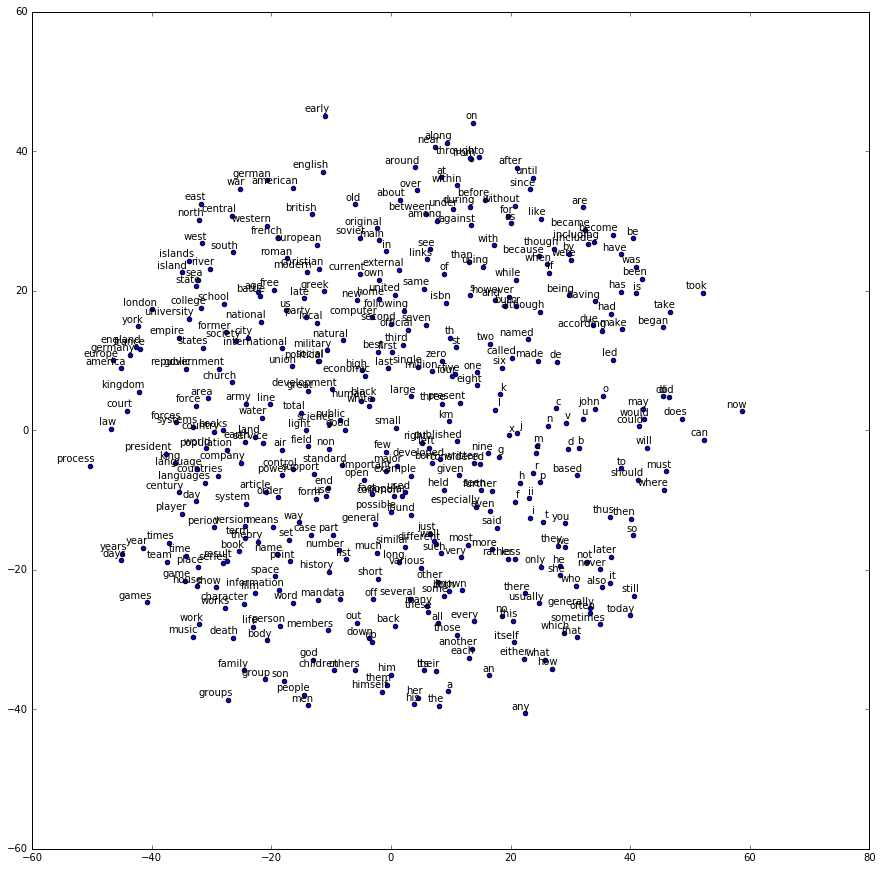

In [16]:
num_points = 400

tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 5000 )
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot_embeddings(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), "More labels than embeddings"
    pylab.figure(figsize = (15,15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x,y)
        pylab.annotate(label, xy = (x,y), xytext = (5,2), textcoords ='offset points', ha = 'right', va = 'bottom')
    pylab.show()
    
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot_embeddings(two_d_embeddings, words)

## Problem

An alternative to skip-gram is another Word2Vec model called **CBOW** (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.


In [17]:
# to be continued